In [219]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from sklearn.model_selection import KFold
from sklearn import linear_model
import math

%matplotlib inline
plt.style.use('seaborn-white')

## Lasso Overview

Least Absolute Shrinkage and Selection Operator

Objective Function:

$$ \begin{eqnarray}
\underset{\beta}{\mathrm{argmin}} RSS_{lasso} (\beta) &=& \frac{1}{n} \underset{\beta}{\mathrm{argmin}} (RSS_{OLS} (\beta) + \lambda |\beta|_{1} )\\
&=& \underset{\beta}{\mathrm{argmin}} \frac{1}{n} ||y - (\beta)X)||^{2}_{2} + \lambda |\beta|_{1} \\ 
&=& f(\beta) + g(\beta)
\end{eqnarray}$$

where $f(\beta)$ is the $RSS_{OLS}$ term, and $g(\beta)$ is the regularization factor for Lasso.

After applying some subdifferentials and subderivatives, we find that the Objective function becomes: 

$$ \begin{eqnarray}
\frac{\partial d}{\partial d \beta_{j}} RSS_{Lasso} + \partial \beta_{j} \lambda \sum^{n}_{j=0} |\beta_{j}|
&=& - \sum^{m}_{i=0} x_{j}^{i} (y^{i} - \sum^{n}_{k \ne j} \theta_{k} x_{k}^{i} ) + \theta_{j} \sum^{m}_{i=1} (x_{j}^{i})^{2} + \partial_{\beta_{j}} \lambda|\beta_{j}| \\ 
&=& - \rho_{j} +  \beta_{j} z + \partial_{\beta_{j}} \lambda|\beta_{j}| \\
\end{eqnarray}$$

Proposed strategy:
- Solve linear system via soft-thresholding with coordinate descent for given values of tuning parameter lambda.
- Tuning lambda via 4-fold Cross validation. k value with lowest mean MSE will be chosen. 

### Lasso from scratch begins here: 

1. The setup: design matrix and response variable (price).
2. Two functions: soft_thresholding and coordinate_descent_lasso are created. 
    - soft_thresholding: returns value of $\beta^{(LASSO)}_{j}$  based on values of the OLS solution $\hat{\beta_{j}^{(OLS)}}$. The process involves finding the first derivative of the LASSO objective function- in whihc the OLS solution is factorized into the product of normalization constant $z_{j}$ and $\rho$. The LASSO solution then becomes a piecewise solution based on the relative value of $\rho$ and $\lambda$: $\rho > lambda$, $\rho < -\lambda$, $-\lambda \le \rho \le \lambda$. soft_thresholding returns these piecewise solutions based on $\rho$ and $\lambda$ values.  

### Importing data and defining functions (soft_threshold, coordinate_descent_lasso, lambda_tune)

In [272]:
# run

def soft_threshold(rho,lamda):
    '''Soft threshold function used for normalized data and lasso regression'''
    if rho < (-1 * lamda):
        return (rho + lamda)
    elif rho >  lamda:
        return (rho - lamda)
    else: 
        return 0

In [278]:
# testing dont run

m,n = X_train.shape
norm = np.linalg.norm(X_train,axis = 0)
for i in range(n):
    if norm[i] != 0:
        X_train[:,i] = (X_train[:,i] - np.mean(X_train[:,i])) / np.std(X_train[:,i])

#Looping until max number of iterations
for i in range(100): 

    #Looping through each coordinate
    for j in range(n):

        #Vectorized implementation
        X_j = X_train[:,j].reshape(-1,1)
        y_pred = X_train @ theta
        y_pred = y_pred.reshape(-1,1)
        rho = X_j.T @ (y_train - y_pred  + theta[j]*X_j)
        rho = float(rho)

        #Checking intercept parameter

        theta[j] =  soft_threshold(rho, 0.12)   

temp = theta.flatten()

<ipython-input-278-0eab38edc365>:17: RuntimeWarning: overflow encountered in matmul
  y_pred = X_train @ theta
<ipython-input-278-0eab38edc365>:17: RuntimeWarning: invalid value encountered in matmul
  y_pred = X_train @ theta
<ipython-input-278-0eab38edc365>:19: RuntimeWarning: invalid value encountered in matmul
  rho = X_j.T @ (y_train - y_pred  + theta[j]*X_j)
<ipython-input-278-0eab38edc365>:19: RuntimeWarning: overflow encountered in multiply
  rho = X_j.T @ (y_train - y_pred  + theta[j]*X_j)
<ipython-input-278-0eab38edc365>:19: RuntimeWarning: invalid value encountered in add
  rho = X_j.T @ (y_train - y_pred  + theta[j]*X_j)
<ipython-input-278-0eab38edc365>:19: RuntimeWarning: overflow encountered in matmul
  rho = X_j.T @ (y_train - y_pred  + theta[j]*X_j)


In [276]:
# run

def coordinate_descent_lasso(theta,X,y,lamda, num_iters=100, intercept = False):
    '''Coordinate gradient descent for lasso regression - for normalized data. 
    The intercept parameter allows to specify whether or not we regularize theta_0'''
    
    m,n = X_train.shape
    norm = np.linalg.norm(X_train,axis = 0)
    for i in range(n):
        if norm[i] != 0:
            X_train[:,i] = (X_train[:,i] - np.mean(X_train[:,i])) / np.std(X_train[:,i])

    #Looping until max number of iterations
    for i in range(100): 

        #Looping through each coordinate
        for j in range(n):

            #Vectorized implementation
            X_j = X_train[:,j].reshape(-1,1)
            y_pred = X_train @ theta
            y_pred = y_pred.reshape(-1,1)
            rho = X_j.T @ (y_train - y_pred  + theta[j]*X_j)
            rho = float(rho)

            #Checking intercept parameter

            theta[j] =  soft_threshold(rho, lamda) 
            
    return theta.flatten()

In [155]:
# run

def lambda_tune(X_train,y_train):
    
    all_mse = list() # 300 total entries (lambda), each entry has 10 entries (10-fold)
    lamda = np.logspace(0,7,300)/10 #Range of lambda values
    
    kf = KFold(n_splits = 10, random_state = True, shuffle = True)

    for l in lamda:                                             # Iterate through all lambda (200)
        mse_vals = list()
        
        for train_index, test_index in kf.split(X_train):       # Iterate through each of 10 folds for each lamda 
            temp_X_train = X_train[train_index]
            temp_y_train = y_train[train_index]
            temp_X_test = X_train[test_index]
            temp_y_test = y_train[test_index]
            
            n,p = temp_X_train.shape
            initial_theta = np.ones((p,1))
            MSE = 0

            theta = coordinate_descent_lasso(initial_theta,temp_X_train,temp_y_train,lamda = l, num_iters=100) # fit lasso model
            y_pred = temp_X_test @ theta                         # Predicted response values based on beta coefficients   
            
            for i in range(len(test_index)):
                MSE += (temp_y_test[i][0] - y_pred[i])**2
            MSE = MSE/n                                         # MSE of each of the 4 lasso models fitted to a given lambda 
            mse_vals.append(MSE)
        all_mse.append(mse_vals)
    return all_mse,lamda

In [251]:
# run

#Loading in Data
df = pd.read_csv("../data/listings.csv")
df.drop(df.columns[0], axis=1, inplace=True)

In [252]:
# run

Y = df["price"]
X = df.drop("price", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
X_train,y_train,X_test,y_test = X_train.to_numpy(),y_train.to_numpy(),X_test.to_numpy(),y_test.to_numpy()
y_train = y_train.reshape(-1,1)

In [186]:
# run

def r2score(y_pred, y):
    rss = np.sum((y_pred - y) ** 2)
    tss = np.sum((y - y.mean()) ** 2)

    r2 = 1 - (rss / tss)
    return r2

In [ ]:
# Comment out if using all data
# 32 variable data: 
X_df = df[
    [
        "minimum_nights",
        "number_of_reviews",
        "reviews_per_month",
        "calculated_host_listings_count",
        "availability_365",
        "neighbourhood_group_Bronx",
        "neighbourhood_group_Brooklyn",
        "neighbourhood_group_Manhattan",
        "neighbourhood_group_Queens",
        "neighbourhood_group_Staten Island",
        "neighbourhood_Midtown",
        "neighbourhood_Lower East Side",
        "neighbourhood_Harlem",
        "neighbourhood_Upper East Side",
        "neighbourhood_Upper West Side",
        "neighbourhood_Washington Heights",
        "neighbourhood_East Harlem",
        "neighbourhood_Chinatown",
        "neighbourhood_East Village",
        "neighbourhood_Financial District",
        "neighbourhood_Morningside Heights",
        "neighbourhood_Inwood",
        "neighbourhood_Hell's Kitchen",
        "neighbourhood_Battery Park City",
        "neighbourhood_Chelsea",
        "neighbourhood_Two Bridges",
        "neighbourhood_Gramercy",
        "neighbourhood_NoHo",
        "neighbourhood_Greenwich Village",
        "neighbourhood_SoHo",
        "room_type_Entire home/apt",
        "room_type_Private room"
    ]
]
X = X_df.to_numpy()
y_df = df[["price"]]
y = y_df.to_numpy()

In [80]:
# 80:20 split for 32-var case

#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=200)

### Fitting Lasso: (No intercept)

In [277]:
# run

# Initialize variables
m,n = X_train.shape
initial_theta = np.ones(n)
theta_list = list()
lamda = np.arange(0.1,10,0.1) #Range of lambda values

#Run lasso regression for each lambda
for l in lamda:
    theta = coordinate_descent_lasso(initial_theta,X_train,y_train,lamda = l, num_iters=100)
    theta_list.append(theta)

# (theta,X,y,lamda = .01, num_iters=100, intercept = False)

#Stack into numpy array
theta_lasso = np.stack(theta_list).T

<ipython-input-276-45a73418d0c9>:21: RuntimeWarning: overflow encountered in matmul
  y_pred = X_train @ theta
<ipython-input-276-45a73418d0c9>:21: RuntimeWarning: invalid value encountered in matmul
  y_pred = X_train @ theta
<ipython-input-276-45a73418d0c9>:23: RuntimeWarning: invalid value encountered in matmul
  rho = X_j.T @ (y_train - y_pred  + theta[j]*X_j)
<ipython-input-276-45a73418d0c9>:23: RuntimeWarning: overflow encountered in multiply
  rho = X_j.T @ (y_train - y_pred  + theta[j]*X_j)
<ipython-input-276-45a73418d0c9>:23: RuntimeWarning: invalid value encountered in add
  rho = X_j.T @ (y_train - y_pred  + theta[j]*X_j)
<ipython-input-276-45a73418d0c9>:23: RuntimeWarning: overflow encountered in matmul
  rho = X_j.T @ (y_train - y_pred  + theta[j]*X_j)


KeyboardInterrupt: 

In [ ]:
# run 

# Visual on Lasso Path for Lambdas
n,_ = theta_lasso.shape
plt.figure(figsize = (12,8))
cols = list(X_df.columns)

for i in range(n):
    plt.plot(lamda, theta_lasso[i], label = cols[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('Coefficients')
plt.title('Lasso Paths')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.axis('tight')

### Tuning Lambda
We conduct 10-fold cross validation:

1. Split training set into 10 partitions. (for each iteration: 9 partitions are used for training, 1 for testing) 
2. 10 lasso models are trained for 300 lambda values.
3. For each lambda value, find the mean MAE of the 10 lasso models. 
3. Select lambda = k that has lowest mean MAE.

In [ ]:
# run
all_mse, lamda = lambda_tune(X_train,y_train)

In [62]:
# run 

# Fitting Lasso on tuned lambda = 0.1241
import timeit
timestart = timeit.default_timer()           # start timer
theta = coordinate_descent_lasso(initial_theta,X_train,y_train,lamda = 0.1241, num_iters=100)
timeend = timeit.default_timer()             # end timer
time_elapsed = (timeend - timestart) # calculate elapsed time

time_elapsed

4.68559230000028

In [67]:
# run

# Computing MSE of our fitted LASSO model
y_pred = X_test@theta
SSE = 0
for i in range(7768):
    SSE += (y_test[i][0] - y_pred[i])**2
MSE = SSE/7768

In [71]:
MSE

704465281047.7428

No handles with labels found to put in legend.


(0.0446683592150963,
 2238721.138568338,
 -174.70674802088823,
 4006.7976486432162)

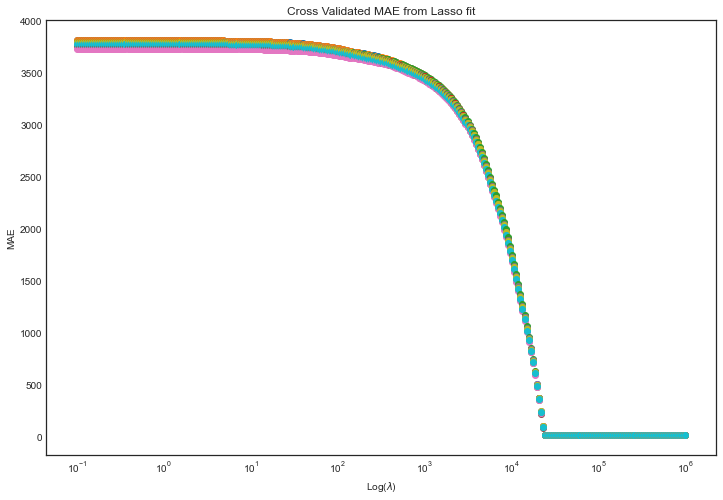

In [129]:
# run 

# Visual of MSE against lamda

n = 300
plt.figure(figsize = (12,8))

for i in range(n):
    for j in range(10):
        plt.scatter(lamda[i], all_mse[i][j])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('MSE')
plt.title('Cross Validated MAE from Lasso fit')
plt.legend()
plt.axis('tight')

In [130]:
# run

# Finding the minimum lamda value
allmeans = list()
for i in range(300):
    allmeans.append(np.mean(all_mse[i]))

min_index = allmeans.index(min(allmeans))
lamda[min_index]

24244.62017082326

### Implementation using sklearn (for comparison)

In [100]:
from sklearn import linear_model

# Fitting lasso model with lambda = 24244
#clf = linear_model.Lasso(alpha=16, fit_intercept = False)
#clf.fit(X_train,y_train)
#clf.coef_

In [103]:
# Initialize variables
m,n = X_train.shape
theta_list_sk = list()
lamda = np.arange(0.01,5,0.01) #Range of lambda values

#Run lasso regression for each lambda
for l in lamda:
    clf = linear_model.Lasso(alpha = l, fit_intercept = False)
    clf.fit(X_train,y_train)
    theta_list_sk.append(clf.coef_)

#Stack into numpy array
theta_lasso_sk = np.stack(theta_list_sk).T

C:\Users\kxu97\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.348e+07, tolerance: 1.629e+05
  model = cd_fast.enet_coordinate_descent(


IndexError: list index out of range

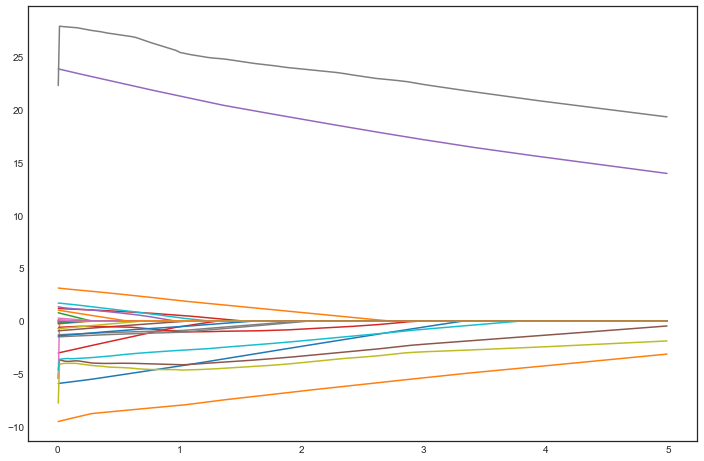

In [104]:
# SK_Lasso Path

#Plot results
n,_ = theta_lasso_sk.shape
plt.figure(figsize = (12,8))

for i in range(n):
    plt.plot(lamda, theta_lasso_sk[i], label = cols[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('Coefficients')
plt.title('Lasso Paths')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.axis('tight')

In [70]:
from sklearn.utils import column_or_1d
y_train = column_or_1d(y_train, warn=True)

<ipython-input-70-e00537395b31>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_train = column_or_1d(y_train, warn=True)


In [71]:
np.shape(y_train)

(31069,)

In [73]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
# define model evaluation method
cv = RepeatedKFold(n_splits=4, n_repeats=3, random_state=1)
# define model
model = LassoCV(alphas=np.logspace(0,4,300)/10, cv=cv, n_jobs=-1)
# fit model
model.fit(X_train, y_train)
# summarize chosen configuration
print('alpha: %f' % model.alpha_)

alpha: 0.100000


In [43]:
def lambda_tune_SK(X_train,y_train,k):
    
    all_mae = list() # 300 total entries (lambda), each entry has k entries (k-fold)
    all_mse = list() # 300 total entries (lambda), each entry has k entries (k-fold)
    lamda = np.logspace(0,7,300)/10 #Range of lambda values
    
    kf = KFold(n_splits = k)

    for l in lamda:                                             # Iterate through all lambda (200)
        mae_vals = list()                                       # list of MAE values for each lambda. Resets for each lambda
        mse_vals = list()
        
        for train_index, test_index in kf.split(X_train):       # Iterate through each of 10 folds for each lamda 
            temp_X_train = X_train[train_index]
            temp_y_train = y_train[train_index]
            temp_X_test = X_train[test_index]
            temp_y_test = y_train[test_index]
            
            MAE = 0
            MSE = 0
            
            clf = linear_model.Lasso(alpha= l , fit_intercept = False)
            clf.fit(temp_X_train,temp_y_train)
            
            y_pred = temp_X_test @ clf.coef_                     # Predicted response values based on beta coefficients                
            for i in range(len(test_index)):
                MAE += abs(temp_y_test[i][0] - y_pred[i])
                MSE += (temp_y_test[i][0] - y_pred[i])**2
            MAE = MAE/len(test_index)                           # MAE of each lasso model (10) for each lambda (300)
            MSE = MSE/len(test_index)                                         # MSE of each lasso model (10) for each lambda (300) 
            mae_vals.append(MAE)
            mse_vals.append(MSE)
        all_mae.append(mae_vals)                                # Appending 10 MAE values from 10 fitted lasso models
        all_mse.append(mse_vals)
    return all_mae, all_mse,lamda

In [48]:
np.shape(X_train)

(31069, 32)

In [50]:
# 3-fold cross validation

all_mae_sk, all_mse_sk, lamda = lambda_tune_SK(X_train,y_train,3)
allmeans = list()
for i in range(300):
    allmeans.append(np.mean(all_mae_sk[i]))

min_index = allmeans.index(min(allmeans))

lamda[min_index] # 0.13818733056536323

0.13818733056536323

In [51]:
# 4-fold cross validation

all_mae_sk, all_mse_sk, lamda = lambda_tune_SK(X_train,y_train,4)
allmeans = list()
for i in range(300):
    allmeans.append(np.mean(all_mae_sk[i]))

min_index = allmeans.index(min(allmeans))
lamda[min_index] # 0.1240639159058832

0.1240639159058832

In [ ]:
# 5-fold cross validation

all_mae_sk, all_mse_sk, lamda = lambda_tune_SK(X_train,y_train,5)
allmeans = list()
for i in range(300):
    allmeans.append(np.mean(all_mae_sk[i]))

min_index = allmeans.index(min(allmeans))
lamda[min_index] # 

In [ ]:
# 6-fold cross validation

all_mae_sk, all_mse_sk, lamda = lambda_tune_SK(X_train,y_train,6)
allmeans = list()
for i in range(300):
    allmeans.append(np.mean(all_mae_sk[i]))

min_index = allmeans.index(min(allmeans))
lamda[min_index] # 

No handles with labels found to put in legend.


(0.0687528918396024, 261.1497606350303, 2255.3286925025554, 51158.17394579791)

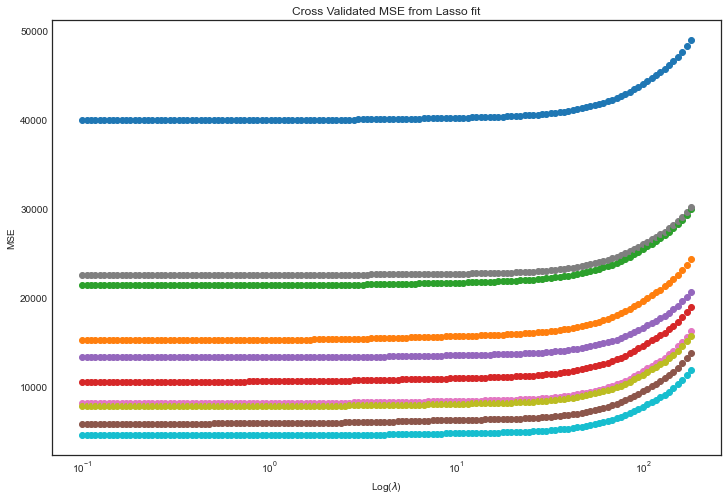

In [290]:
# Plotting MSE against lamda (sk-lasso model)

n = 300
plt.figure(figsize = (12,8))

for i in range(140):
    for j in range(10):
        plt.scatter(lamda[i], all_mse_sk[i][j])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('MSE')
plt.title('Cross Validated MSE from Lasso fit')
plt.legend()
plt.axis('tight')

In [265]:
# Finding the minimum lamda value
allmeans = list()
for i in range(300):
    allmeans.append(np.mean(all_mse_sk[i]))

min_index = allmeans.index(min(allmeans))
lamda[min_index]

0.1

In [146]:
# [FROM SCRATCH] Tuned hyperparameter model:

# Initialize variables
m,n = X_train.shape
initial_theta = np.ones((n,1))

#Run lasso regression for tuned lambda
theta = coordinate_descent_lasso(initial_theta,X_train,y_train,lamda = 24244, num_iters=300)
theta

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        , 909.26194755,   0.        ])

## Generating final model 
- Recap: 
    - Hyperparameter tuning: 
        - Coordinate_descent: lambda = 24244 (minimum MSE & minimum MAE) 
        - Sk_lasso: lambda = 16.75252472408214 (MAE), lambda = 0.1 (MSE)
    - Lasso model without intercept is chosen because of strange lasso path that has increasing beta value.
    
 - SK_Lasso Model: 5 variables: 
     - availability_365, 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'room_type_Entire home/apt', 'room_type_Private room'.
     - $$y = 17.21323117 X_{availability365} + 2.6954145 X_{neighbourhoodgroup(Brooklyn)} + 27.00013305 X_{neighbourhoodgroup(Manhattan)} + 68.55946047 X_{roomtype(home/apt)} + 14.12280336 X_{roomtype(Private room)} + \epsilon$$ with $\epsilon$: noise term, and $\lambda = 16.75252472408214$ tuned from minimium MAE
 - Coordinate_descent Model: 1 variable: 
     - $y = 909.26194755 X_{room_type_Private room} + \epsilon$ with $\lambda = 24244$

In [72]:
from sklearn.linear_model import LassoCV
SSE = 0
MSE = 0
reg = LassoCV(cv=4, random_state=0).fit(X_train, y_train)
y_pred = reg.predict(X_test)
for i in range(len(y_test)):
    SSE += (y_test[i][0] - y_pred[i])**2
MSE = SSE/len(y_test)
MSE
#print(reg.score(X_test, y_test))

C:\Users\kxu97\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


21164.79181272181

In [73]:
math.sqrt(MSE)

145.48124213355416

In [56]:
clf = linear_model.Lasso(alpha= 0.1240639159058832 , fit_intercept = False)
clf.fit(X_train,y_train)
clf.coef_
#clf.score(X_train,y_train)

array([-1.82464069e-01, -1.82117495e-01, -6.95580768e-01, -1.18862286e-01,
        1.68603554e-01, -0.00000000e+00,  3.19489793e+01,  1.03751173e+02,
        1.19852278e+01, -0.00000000e+00,  4.02303655e+01, -9.67773714e+00,
       -6.26200141e+01, -4.76993652e+01, -1.28789731e+01, -8.13895706e+01,
       -4.17801134e+01, -2.65955374e+01, -2.62925742e+01, -0.00000000e+00,
       -5.03509698e+01, -7.69919226e+01, -1.32152950e+01, -0.00000000e+00,
        7.64971159e-02, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        1.51316531e+01,  6.46189443e+01,  1.29609606e+02,  2.93556169e+01])

In [59]:
num = [0,1,2,3,4,6,7,8,10,11,12,13,14,15,16,17,18,20,21,22,24,28,29,30,31]
for i in num:
    print(cols[i])

minimum_nights
number_of_reviews
reviews_per_month
calculated_host_listings_count
availability_365
neighbourhood_group_Brooklyn
neighbourhood_group_Manhattan
neighbourhood_group_Queens
neighbourhood_Midtown
neighbourhood_Lower East Side
neighbourhood_Harlem
neighbourhood_Upper East Side
neighbourhood_Upper West Side
neighbourhood_Washington Heights
neighbourhood_East Harlem
neighbourhood_Chinatown
neighbourhood_East Village
neighbourhood_Morningside Heights
neighbourhood_Inwood
neighbourhood_Hell's Kitchen
neighbourhood_Chelsea
neighbourhood_Greenwich Village
neighbourhood_SoHo
room_type_Entire home/apt
room_type_Private room


In [55]:
np.shape(X_test)

(7768, 32)

In [58]:
r_adj = ((1 - 0.11835175406167764) * (31069 + 7768)) / (31069 + 7768 - 25 - 1)
r_adj

0.8822388737086554

In [181]:
#cols[4] # availability_365
#cols[6] # 'neighbourhood_group_Brooklyn'
#cols[7] # 'neighbourhood_group_Manhattan'
#cols[30] # 'room_type_Entire home/apt'
#cols[31] # 'room_type_Private room'

'room_type_Private room'

In [216]:
# Testing MSE of model against testing data:
import timeit
timestart = timeit.default_timer()           # start timer
clf = linear_model.Lasso(alpha= 16.75252472408214 , fit_intercept = False)
clf.fit(X_train,y_train)
timeend = timeit.default_timer()             # end timer
time_elapsed = (timeend - timestart) # calculate elapsed time

y_pred = X_test@clf.coef_
y_pred
MSE = 0
MAE = 0
n = len(y_test)
for i in range(n):
    MSE += (y_test[i][0] - y_pred[i])**2
    MAE += abs(y_test[i][0] - y_pred[i])
MSE = MSE/n
MAE = MAE/n

In [217]:
print("The MSE of our Lasso model is: ",MSE)
print("The MAE of our Lasso model is: ",MAE)
print("The training run-time for our Lasso model is: ",time_elapsed)

The MSE of our Lasso model is:  8517915.669298718
The MAE of our Lasso model is:  1933.9078181510783
The training run-time for our Lasso model is:  0.04226710001239553


In [220]:
import numpy
 
corr_matrix = numpy.corrcoef(y_test[:,0], y_pred)
corr = corr_matrix[0,1]
R_sq = corr**2
 
print(R_sq)

0.008392621529298826


## Evaluation:
- Sparse solution is created-- that is robust against multicollinearity. Dimension is reduced from 32 variables to 5 of the most important ones. 
- MSE = 8517915.669298718
- MAE = 1933.9078181510783
- Run time: 0.04226710001239553 seconds
- R^2: 0.008392621529298826

## Testing with Iris Dataset:

In [222]:
iris = pd.read_csv(
    "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv"
)
iris = iris.drop("species", axis=1)
display(iris)

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [224]:
def standardizeData(data):
    # Takes pandas dataframe and standardizes it iteratively
    for column in data:
        if (data[column] != 0).sum() == 0:  # If the column is all zeros
            continue  # No need to standardize all zeros (thus dividing by zero)
        else:
            data[column] = (data[column] - np.mean(data[column])) / np.std(data[column])
    return data

In [226]:
Xtrain_iris, Xtest_iris, Ytrain_iris, Ytest_iris = train_test_split(
    iris.drop("sepal_length", axis=1),
    iris["sepal_length"],
    test_size=0.2,
    random_state=42,
)

# Standardize our X matrices
Xtrain_iris, Xtest_iris = standardizeData(Xtrain_iris), standardizeData(Xtest_iris)

# Do the model
model = linear_model.Lasso(alpha= 16.75252472408214 , fit_intercept = False)
model.fit(Xtrain_iris,Ytrain_iris)

Y_pred_iris = model.predict(Xtest_iris)
display(pd.DataFrame({"Predictions": Y_pred_iris, "Actual": Ytest_iris}).head())

,Predictions,Actual
73,0.0,6.1
18,0.0,5.7
118,0.0,7.7
78,0.0,6.0
76,0.0,6.8
